# Import Libraries

In [1]:
#sklearn models scalers metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import learning_curve
from scipy.interpolate import make_interp_spline, BSpline

#pandas np plt
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

#supress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Exploration

The paper used l-of-C encoding to encode categorical variables. pandas get_dummies class was used to replicate this hopefully leading to similar results

In [2]:
# read file
df_ori=pd.read_csv('forestfires.csv')

#use pandas dummy encoder to encode the categorical variables
df = pd.get_dummies(df_ori,drop_first=True)
df.tail()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_may,month_nov,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,1,0,0,0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,1,0,0,0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,1,0,0,0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,1,0,0,0,0
516,6,3,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,...,0,1,0,0,0,0,0,0,1,0


In [3]:
# rearrange columns
cols = df.columns.tolist()
cols = cols[0:2] + cols[-17:] + cols[2:-17]
df = df[cols]

The paper transformed the skewed area target variable using the logarithm function y = ln(x+1)

In [4]:
# create new column the transformed area feature
df['larea'] = np.log(df.area+1)

Plot of area feature and log transformed area feature

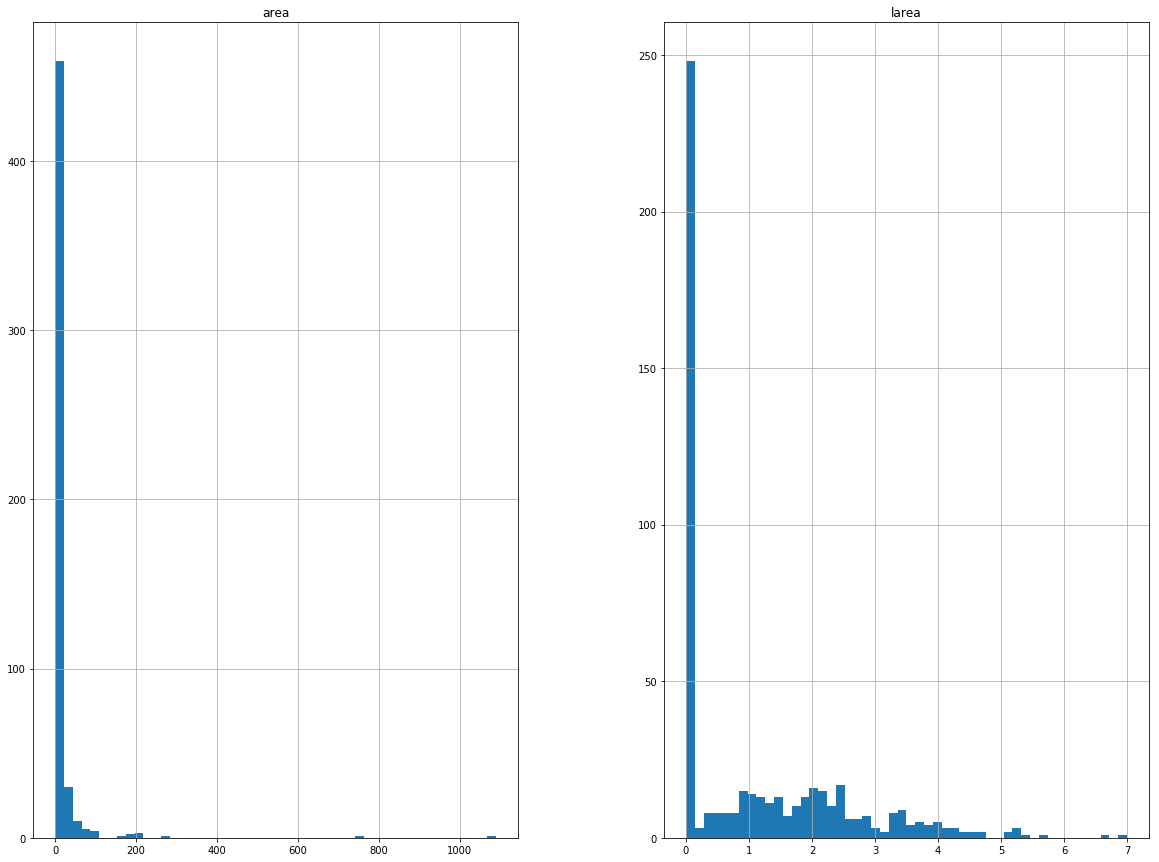

In [5]:
df[['area','larea']].hist(bins=50,figsize=(20,15))
plt.show()

In [6]:
column_names = ['X','Y','month_aug','month_dec','month_feb','month_jan','month_jul','month_jun','month_mar','month_may','month_nov','month_oct','month_sep','day_mon','day_sat','day_sun','day_thu','day_tue','day_wed','FFMC','DMC','DC','ISI','temp','RH','wind','rain','area', 'larea']     

In [7]:
feature_names = column_names[:-2]

# Model Configurations and Evaluation

The details given in section 4 of the paper were used to configure the models for the expetiments

## Feature Selections

In [8]:
X_STFWI = df.values[:,0:23]
X_STM = df.values[:,np.r_[0:19,23:27]]
X_FWI = df.values[:,19:23]
X_M = df.values[:,23:27]
X_STFWI_bk = X_STFWI.copy()
X_STM_bk = X_STM.copy()
X_FWI_bk = X_FWI.copy()
X_M_bk = X_M.copy()

## Target Variable

In [9]:
y = df[['larea']].values

## Naive Mean Predictor

In [10]:
df['mean_val'] = round(np.mean(df.area.values),2)

In [11]:
print("\n MAD for Naive Mean Predictor: ",mean_absolute_error(df.area.values, df.mean_val.values),"\tRMSE for Naive Mean Predictor: ",np.sqrt(mean_squared_error(df.area.values, df.mean_val.values)))


 MAD for Naive Mean Predictor:  18.568742746615087 	RMSE for Naive Mean Predictor:  63.59422604047205


## Decision Tree 

In [12]:
tree = DecisionTreeRegressor(criterion= "mse", random_state=66)
F_M = np.zeros(shape=(517,30))
F_FWI = np.zeros(shape=(517,30))
F_STM = np.zeros(shape=(517,30))
F_STFWI = np.zeros(shape=(517,30))
for fname,f,fs in zip(['STFWI', 'STM', 'FWI', 'M'],[F_STFWI, F_STM, F_FWI, F_M],[X_STFWI, X_STM, X_FWI, X_M]):
    for i in range(30):
        k_fold = KFold(n_splits=10, shuffle=True, random_state=i)
        y_pred = cross_val_predict(tree, fs, y, cv = k_fold)
        y_pred2 = np.array(y_pred)
        f[:, i] = y_pred2
    
    f_predicted = np.mean(f, axis = 1)
    natural_f = np.exp(f_predicted) - 1
    for i in range(len(natural_f)):
        if natural_f[i] < 0:
            natural_f[i] = 0
        
    print("\n MAD for ", fname, ": ", mean_absolute_error(df.area.values, natural_f), "\tRMSE for ", fname, ": ", np.sqrt(mean_squared_error(df.area.values, natural_f)))
    


 MAD for  STFWI :  16.50947742861481 	RMSE for  STFWI :  72.07238267768658

 MAD for  STM :  13.836781182847941 	RMSE for  STM :  64.72417369405686

 MAD for  FWI :  13.732063247073564 	RMSE for  FWI :  63.90315466489745

 MAD for  M :  14.476991183911295 	RMSE for  M :  63.565557569516635


## Random Forest

In [13]:
rf = RandomForestRegressor(random_state=66)
F_M = np.zeros(shape=(517,30))
F_FWI = np.zeros(shape=(517,30))
F_STM = np.zeros(shape=(517,30))
F_STFWI = np.zeros(shape=(517,30))
for fname,f,fs in zip(['STFWI', 'STM', 'FWI', 'M'],[F_STFWI, F_STM, F_FWI, F_M],[X_STFWI, X_STM, X_FWI, X_M]):
    for i in range(30):
        k_fold = KFold(n_splits=10, shuffle=True, random_state=i)
        y_pred = cross_val_predict(rf, fs, y.ravel(), cv = k_fold)
        y_pred2 = np.array(y_pred)
        f[:, i] = y_pred2
    
    f_predicted = np.mean(f, axis = 1)
    natural_f = np.exp(f_predicted) - 1
    for i in range(len(natural_f)):
        if natural_f[i] < 0:
            natural_f[i] = 0
    f_predicted_m_rf = natural_f
    print("\n MAD for ", fname, ": ", mean_absolute_error(df.area.values, natural_f), "\tRMSE for ", fname, ": ", np.sqrt(mean_squared_error(df.area.values, natural_f)))
    


 MAD for  STFWI :  13.722712681694713 	RMSE for  STFWI :  64.55388410775448

 MAD for  STM :  13.153766457370013 	RMSE for  STM :  64.50284474245088

 MAD for  FWI :  13.555289990101153 	RMSE for  FWI :  64.08969797466243

 MAD for  M :  13.175747985668938 	RMSE for  M :  63.85453662848482


## Multiple Linear Regression 

In [14]:
reg = LinearRegression()
F_M = np.zeros(shape=(517,30))
F_FWI = np.zeros(shape=(517,30))
F_STM = np.zeros(shape=(517,30))
F_STFWI = np.zeros(shape=(517,30))
for fname,f,fs in zip(['STFWI', 'STM', 'FWI', 'M'],[F_STFWI, F_STM, F_FWI, F_M],[X_STFWI, X_STM, X_FWI, X_M]):
    for i in range(30):
        k_fold = KFold(n_splits=10, shuffle=True, random_state=i)
        y_pred = cross_val_predict(reg, fs, y.ravel(), cv = k_fold)
        y_pred2 = np.array(y_pred)
        f[:, i] = y_pred2
    
    f_predicted = np.mean(f, axis = 1)
    natural_f = np.exp(f_predicted) - 1
    for i in range(len(natural_f)):
        if natural_f[i] < 0:
            natural_f[i] = 0
    print("\n MAD for ", fname, ": ", mean_absolute_error(df.area.values, natural_f), "\tRMSE for ", fname, ": ", np.sqrt(mean_squared_error(df.area.values, natural_f)))
    


 MAD for  STFWI :  13.039844578109836 	RMSE for  STFWI :  64.45414519304298

 MAD for  STM :  13.04437132578227 	RMSE for  STM :  64.45861626193569

 MAD for  FWI :  12.992488179119764 	RMSE for  FWI :  64.49173509974511

 MAD for  M :  13.003938821145786 	RMSE for  M :  64.48140842918858


Based on the research, the input features need to be scaled for the NN and SVM 

In [15]:
sc = StandardScaler()
df_scale = sc.fit(df.values[:,:-2]).transform(df.values[:,:-2])

In [16]:
X_STFWI = df_scale[:,0:23]
X_STM = df_scale[:,np.r_[0:19,23:27]]
X_FWI = df_scale[:,19:23]
X_M = df_scale[:,23:27]


## Grid Search: Support Vector Machine 

In [17]:
svr = SVR()
hyperparams = [{'gamma':[2**-9,2**-7,2**-5,2**-3,2**-1]}]
grid_search = GridSearchCV(svr, hyperparams, cv=10)
for fname,f,fs in zip(['STFWI', 'STM', 'FWI', 'M'],[F_STFWI, F_STM, F_FWI, F_M],[X_STFWI, X_STM, X_FWI, X_M]):
    grid_search.fit(fs, y.ravel())
    print("\nGamma for ", fname, ": ", grid_search.best_params_)


Gamma for  STFWI :  {'gamma': 0.001953125}

Gamma for  STM :  {'gamma': 0.5}

Gamma for  FWI :  {'gamma': 0.5}

Gamma for  M :  {'gamma': 0.125}


## Support Vector Machine: Paper Grid Search Parameters Used

In [18]:
F_M = np.zeros(shape=(517,30))
F_FWI = np.zeros(shape=(517,30))
F_STM = np.zeros(shape=(517,30))
F_STFWI = np.zeros(shape=(517,30))
for fname,f,fs,g in zip(['STFWI', 'STM', 'FWI', 'M'],[F_STFWI, F_STM, F_FWI, F_M],[X_STFWI, X_STM, X_FWI, X_M],[2**-5, 2**-3, 2**-3, 2**-3]):
    svr = SVR(gamma=g)
    for i in range(30):
        k_fold = KFold(n_splits=10, shuffle=True, random_state=i)
        y_pred = cross_val_predict(svr, fs, y.ravel(), cv = k_fold)
        y_pred2 = np.array(y_pred)
        f[:, i] = y_pred2
    
    f_predicted = np.mean(f, axis = 1)
    natural_f = np.exp(f_predicted) - 1
    for i in range(len(natural_f)):
        if natural_f[i] < 0:
            natural_f[i] = 0
    print("\n MAD for ", fname, ": ", mean_absolute_error(df.area.values, natural_f), "\tRMSE for ", fname, ": ", np.sqrt(mean_squared_error(df.area.values, natural_f)),"\tgamma: ",g)
    


 MAD for  STFWI :  12.801721284321381 	RMSE for  STFWI :  64.70284960966119 	gamma:  0.03125

 MAD for  STM :  12.859065954795161 	RMSE for  STM :  64.71496679882961 	gamma:  0.125

 MAD for  FWI :  12.889905372979028 	RMSE for  FWI :  64.75691339121498 	gamma:  0.125

 MAD for  M :  12.68864073448931 	RMSE for  M :  64.69439095065047 	gamma:  0.125


## Support Vector Machine: My Grid Search Parameters Used

In [19]:
F_M = np.zeros(shape=(517,30))
F_FWI = np.zeros(shape=(517,30))
F_STM = np.zeros(shape=(517,30))
F_STFWI = np.zeros(shape=(517,30))
for fname,f,fs,g in zip(['STFWI', 'STM', 'FWI', 'M'],[F_STFWI, F_STM, F_FWI, F_M],[X_STFWI, X_STM, X_FWI, X_M],[2**-9, 2**-1, 2**-1, 2**-3]):
    svr = SVR(gamma=g)
    for i in range(30):
        k_fold = KFold(n_splits=10, shuffle=True, random_state=i)
        y_pred = cross_val_predict(svr, fs, y.ravel(), cv = k_fold)
        y_pred2 = np.array(y_pred)
        f[:, i] = y_pred2
    
    f_predicted = np.mean(f, axis = 1)
    natural_f = np.exp(f_predicted) - 1
    for i in range(len(natural_f)):
        if natural_f[i] < 0:
            natural_f[i] = 0
    f_predicted_m_svm = natural_f
    print("\n MAD for ", fname, ": ", mean_absolute_error(df.area.values, natural_f), "\tRMSE for ", fname, ": ", np.sqrt(mean_squared_error(df.area.values, natural_f)),"\tgamma: ",g)
    #print("\n",svr)
    


 MAD for  STFWI :  12.785821683381517 	RMSE for  STFWI :  64.72536088442423 	gamma:  0.001953125

 MAD for  STM :  12.859509436622591 	RMSE for  STM :  64.68536021131251 	gamma:  0.5

 MAD for  FWI :  12.82134520002155 	RMSE for  FWI :  64.73318932697072 	gamma:  0.5

 MAD for  M :  12.68864073448931 	RMSE for  M :  64.69439095065047 	gamma:  0.125


## Grid Search: Neural Network

In [20]:
mlp = MLPRegressor(activation='identity',solver='lbfgs',max_iter=100,n_iter_no_change =3,random_state=66)

param_grid = [{'hidden_layer_sizes':[2,4,6,8]}]
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=10)
for fname,f,fs in zip(['STFWI', 'STM', 'FWI', 'M'],[F_STFWI, F_STM, F_FWI, F_M],[X_STFWI, X_STM, X_FWI, X_M]):
    grid_search.fit(X_STFWI, y.ravel())
    print("\nH for ", fname, ": ", grid_search.best_params_)


H for  STFWI :  {'hidden_layer_sizes': 4}

H for  STM :  {'hidden_layer_sizes': 4}

H for  FWI :  {'hidden_layer_sizes': 4}

H for  M :  {'hidden_layer_sizes': 4}


## Neural Network: Paper Grid Search Parameters Used

In [21]:
F_M = np.zeros(shape=(517,30))
F_FWI = np.zeros(shape=(517,30))
F_STM = np.zeros(shape=(517,30))
F_STFWI = np.zeros(shape=(517,30))
for fname,f,fs,h in zip(['STFWI', 'STM', 'FWI', 'M'],[F_STFWI, F_STM, F_FWI, F_M],[X_STFWI, X_STM, X_FWI, X_M],[4, 6, 4, 4]):
    mlp = MLPRegressor(hidden_layer_sizes=h,activation='identity',solver='lbfgs',max_iter=100,n_iter_no_change =3,random_state=66)
    for i in range(30):
        k_fold = KFold(n_splits=10, shuffle=True, random_state=i)
        y_pred = cross_val_predict(mlp, fs, y.ravel(), cv = k_fold)
        y_pred2 = np.array(y_pred)
        f[:, i] = y_pred2
    
    f_predicted = np.mean(f, axis = 1)
    natural_f = np.exp(f_predicted) - 1
    for i in range(len(natural_f)):
        if natural_f[i] < 0:
            natural_f[i] = 0
    print("\n MAD for ", fname, ": ", mean_absolute_error(df.area.values, natural_f), "\tRMSE for ", fname, ": ", np.sqrt(mean_squared_error(df.area.values, natural_f)),"\tH: ",h)
    #print("\n",mlp)
    


 MAD for  STFWI :  13.022265135598081 	RMSE for  STFWI :  64.44416382078353 	H:  4

 MAD for  STM :  13.042695254784741 	RMSE for  STM :  64.4562448228962 	H:  6

 MAD for  FWI :  12.992497065480185 	RMSE for  FWI :  64.49173658905585 	H:  4

 MAD for  M :  13.003923523879157 	RMSE for  M :  64.48142368671304 	H:  4


## Neural Network: My Grid Search Parameters Used

In [22]:
F_M = np.zeros(shape=(517,30))
F_FWI = np.zeros(shape=(517,30))
F_STM = np.zeros(shape=(517,30))
F_STFWI = np.zeros(shape=(517,30))
for fname,f,fs,h in zip(['STFWI', 'STM', 'FWI', 'M'],[F_STFWI, F_STM, F_FWI, F_M],[X_STFWI, X_STM, X_FWI, X_M],[4, 4, 4, 4]):
    mlp = MLPRegressor(hidden_layer_sizes=h,activation='identity',solver='lbfgs',max_iter=100,n_iter_no_change =3,random_state=66)
    for i in range(30):
        k_fold = KFold(n_splits=10, shuffle=True, random_state=i)
        y_pred = cross_val_predict(mlp, fs, y.ravel(), cv = k_fold)
        y_pred2 = np.array(y_pred)
        f[:, i] = y_pred2
    
    f_predicted = np.mean(f, axis = 1)
    natural_f = np.exp(f_predicted) - 1
    for i in range(len(natural_f)):
        if natural_f[i] < 0:
            natural_f[i] = 0
    f_predicted_m_nn = natural_f
    print("\n MAD for ", fname, ": ", mean_absolute_error(df.area.values, natural_f), "\tRMSE for ", fname, ": ", np.sqrt(mean_squared_error(df.area.values, natural_f)),"\tH: ",h)
    #print("\n",mlp)
    


 MAD for  STFWI :  13.022265135598081 	RMSE for  STFWI :  64.44416382078353 	H:  4

 MAD for  STM :  13.007725433879637 	RMSE for  STM :  64.43862031081514 	H:  4

 MAD for  FWI :  12.992497065480185 	RMSE for  FWI :  64.49173658905585 	H:  4

 MAD for  M :  13.003923523879157 	RMSE for  M :  64.48142368671304 	H:  4


# Regression Error Characteristic (REC) Curve

In [23]:
ae1 = np.linspace(0, 20, num=300, endpoint=False)
#ae1

In [24]:
naive_df = {'y_vals':  df.area.values,
        'mean_val': df.mean_val.values
        }
df_naive = pd.DataFrame(naive_df, columns = ['y_vals','mean_val'])
df_naive['diff'] = np.abs(df_naive.y_vals-df_naive.mean_val)

In [25]:
naive_perc1 = []
for i in ae1:
    v = (df_naive['diff'] <= i).values.sum()
    naive_perc1.append((v/517)*100)

#naive_perc1

In [26]:
svm_df = {'y_vals':  df.area.values,
        'pred_val': f_predicted_m_svm
        }
df_svm = pd.DataFrame(svm_df, columns = ['y_vals','pred_val'])
df_svm['diff'] = np.abs(df_svm.y_vals-df_svm.pred_val)

In [27]:
svm_perc1 = []
for i in ae1:
    v = (df_svm['diff'] <= i).values.sum()
    svm_perc1.append((v/517)*100)

#svm_perc1

In [28]:
rf_df = {'y_vals':  df.area.values,
        'pred_val': f_predicted_m_rf
        }
df_rf = pd.DataFrame(rf_df, columns = ['y_vals','pred_val'])
df_rf['diff'] = np.abs(df_rf.y_vals-df_rf.pred_val)

In [29]:
rf_perc1 = []
for i in ae1:
    v = (df_rf['diff'] <= i).values.sum()
    rf_perc1.append((v/517)*100)

#rf_perc1

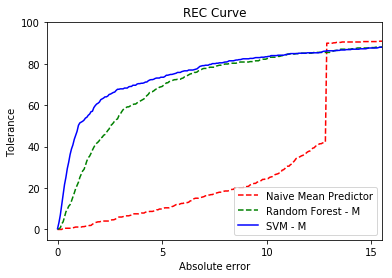

In [30]:
plt.ylim(-5, 100)
plt.xlim(-0.5,15.5)
plt.title('REC Curve')
plt.ylabel('Tolerance')
plt.xlabel('Absolute error')
plt.xticks(np.arange(0, 20, step=5))
plt.plot(ae1,naive_perc1, 'r--',label='Naive Mean Predictor')
plt.plot(ae1,rf_perc1, 'g--',label='Random Forest - M')
plt.plot(ae1,svm_perc1, 'b',label='SVM - M')
plt.legend(loc='lower right')